In [1]:
import os
import json
import pandas as pd
import re
import matplotlib.pyplot as plt


def read_jsonl_file(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()

    # Read the first JSON object (assume it's the multi-line config)
    config_lines = []
    i = 0
    for i, line in enumerate(lines):
        config_lines.append(line)
        if line.strip() == "}":
            break

    config_str = "".join(config_lines)
    config = json.loads(config_str)

    # Read the rest as JSONL
    entries = [json.loads(line) for line in lines[i + 1 :] if line.strip()]
    return config, entries


def extract_last_values(jsonl_filepath, success_keyword="success_begin_with"):
    """
    Extracts the 'step' and 'time_min' values from the last entry in a JSONL file.

    Args:
        jsonl_filepath (str): Path to the JSONL file
        success_keyword (str): Keyword to identify success in the JSONL file

    Returns:
        tuple: (step, time_min) values from the last entry
    """
    last_step = None
    last_time_min = None
    try:
        config, entries = read_jsonl_file(jsonl_filepath)
        if entries:
            last_entry = entries[-1]
            if "step" in last_entry and "time_min" in last_entry:
                last_step = last_entry["step"]
                last_time_min = last_entry["time_min"]
                suffix = last_entry.get("suffix", None)

            # individual sample attack
            if success_keyword in last_entry:
                success = last_entry[success_keyword]
            else:
                success = False

    except Exception as e:
        print(f"Error reading file {jsonl_filepath}: {e}")

    return last_step, last_time_min, suffix, success


def extract_n_from_filename(filename, keyword="sample"):
    """
    Extract the number of samples from the filename.

    Args:
        filename (str): Filename like 'bs512_seed0_l5_t1.0_static_k256_1samples.jsonl'

    Returns:
        int: Number of samples
    """
    if keyword == "sample":
        match = re.search(r"(\d+)samples\.jsonl$", filename)
    elif keyword == "checkpoint":
        match = re.search(r"checkpoint_(\d+)\.jsonl$", filename)
    if match:
        return int(match.group(1))
    return None


def process_experiments_folder(
    base_folder="experiments", dir_keyword="checkpoint", defense_type="prompt_injection"
):
    """
    Process all checkpoints and JSONL files in the experiments folder.

    Args:
        base_folder (str): Path to the experiments folder
        dir_keyword (str): Keyword to identify the directory ('checkpoint' or 'sample')

    Returns:
        pandas.DataFrame: DataFrame containing checkpoint, nsamples, step, and time_min
    """
    if defense_type == "prompt_injection":
        success_keyword = "success_begin_with"
    elif defense_type == "jailbreak":
        success_keyword = "jailbroken"

    results = []

    if not os.path.exists(base_folder):
        print(f"Error: {base_folder} directory not found.")
        return pd.DataFrame()

    if dir_keyword == "checkpoint":
        # Walk through all subdirectories
        for root, dirs, files in os.walk(base_folder):
            # Check if this is a checkpoint directory
            checkpoint_match = re.search(r"checkpoint_(\d+)", root)
            if checkpoint_match:
                checkpoint_num = int(checkpoint_match.group(1))

                # Process all JSONL files in this checkpoint directory
                for file in files:
                    if file.endswith(".jsonl"):
                        nsamples = extract_n_from_filename(file, "sample")
                        if nsamples is not None:
                            jsonl_path = os.path.join(root, file)
                            step, time_min, suffix, num_success = extract_last_values(
                                jsonl_path, success_keyword
                            )

                            if step is not None and time_min is not None:
                                results.append(
                                    {
                                        "checkpoint": checkpoint_num,
                                        "nsamples": nsamples,
                                        "step": step,
                                        "suffix": suffix,
                                        "time_min": time_min,
                                        f"num_{success_keyword}": num_success,
                                    }
                                )
    elif dir_keyword == "sample":
        # Walk through all subdirectories
        for root, dirs, files in os.walk(base_folder):
            # Check if this is a sample directory
            sample_match = re.search(r"sample_(\d+)", root)
            if sample_match:
                sample_num = int(sample_match.group(1))

                # Process all JSONL files in this sample directory
                for file in files:
                    if file.endswith(".jsonl"):
                        checkpoint_num = extract_n_from_filename(file, "checkpoint")
                        if checkpoint_num is not None:
                            jsonl_path = os.path.join(root, file)
                            step, time_min, suffix, sucess = extract_last_values(
                                jsonl_path, success_keyword
                            )

                            if step is not None and time_min is not None:
                                results.append(
                                    {
                                        "sample": sample_num,
                                        "checkpoint_num": checkpoint_num,
                                        "step": step,
                                        "suffix": suffix,
                                        "time_min": time_min,
                                        f"{success_keyword}": sucess,
                                    }
                                )

    df = pd.DataFrame(results)

    if not df.empty:
        if dir_keyword == "checkpoint":
            keys = ["checkpoint", "nsamples"]
        elif dir_keyword == "sample":
            keys = ["sample", "checkpoint_num"]
        df = df.sort_values(keys).reset_index(drop=True)

    if dir_keyword == "sample":
        df["total_steps"] = df.groupby("sample")["step"].cumsum()

    if dir_keyword == "checkpoint":
        df["total_steps"] = df.groupby("checkpoint")["step"].cumsum()

    return df

In [3]:
def get_files_in_folder(
    folder_path,
    files_index: tuple = None,
    file_keyword="sample",
    selected_file_kw_values: list = None,
):
    """
    Get all files in a folder.

    Args:
        folder_path (str): Path to the folder
        files_index (tuple, optional): Tuple of start and end index for filtering. Defaults to None, which means no filtering.
        file_keyword (str): Keyword to identify the file type ('sample' or 'checkpoint'). Defaults to 'sample'.

    Returns:
        list: List of file paths
    """
    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_paths.append(os.path.join(root, file))

    # sort the file paths by the number of samples
    file_paths.sort(key=lambda x: extract_n_from_filename(x, file_keyword))

    # if selected_file_kw_values is not None, filter the file paths
    if selected_file_kw_values is not None:
        file_paths = [
            fp for fp in file_paths if any(kw in fp for kw in selected_file_kw_values)
        ]

    # if files_index is not None, filter the file paths
    if files_index is not None:
        start_index, end_index = files_index
        file_paths = file_paths[start_index:end_index]

    return file_paths

In [ ]:
import math


def sequence_probability(avg_cross_entropy_loss, num_tokens=2):
    return math.exp(-num_tokens * avg_cross_entropy_loss)

In [5]:
def plot_successprob_individual_sample(
    filepaths_lists_by_algo,
    titles=None,
    main_title='p("Hacked") vs GCG steps',
    figsize=(60, 10),
    font_size=18,
    font_size_theta=18,
    success_marker_size=20,
    line_weight=3,
    algo_names=None,
    algo_colors=None,
    algo_final_successes=None,
):
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(left=0.12, right=0.95, top=0.9, bottom=0.12)

    # Track the cumulative steps for each algorithm
    cumulative_steps_algo1 = 0
    cumulative_steps_algo2 = 0
    checkpoint_boundaries = []

    last_step_algo1 = None
    last_step_algo2 = None

    # Process each checkpoint file
    for i, checkpoint_file in enumerate(filepaths_lists_by_algo[0]):
        config_algo1, entries_algo1 = read_jsonl_file(checkpoint_file)
        checkpoint_num = config_algo1["checkpoint"]
        if i == 0:
            starting_step = 50000 - config_algo1["num_steps_total"]
            cumulative_steps_algo1 = starting_step
            cumulative_steps_algo2 = starting_step

        # Get the corresponding file in algo2_folder
        checkpoint_file_algo2 = filepaths_lists_by_algo[1][i]
        config_algo2, entries_algo2 = read_jsonl_file(checkpoint_file_algo2)

        # Extract step and loss values for algo1
        steps_algo1 = [entry["step"] for entry in entries_algo1]
        prob_values_algo1 = [
            sequence_probability(entry["loss"]) for entry in entries_algo1
        ]

        # Adjust steps for algo1 by adding cumulative steps from previous checkpoints
        adjusted_steps_algo1 = [step + cumulative_steps_algo1 for step in steps_algo1]

        # For algo2, we only want to plot up to the max step in algo1
        max_step_algo1_original = max(steps_algo1) if steps_algo1 else 0

        # Filter algo2 data to only include steps <= max_step_algo1
        filtered_data_algo2 = [
            entry for entry in entries_algo2 if entry["step"] <= max_step_algo1_original
        ]
        steps_algo2 = [entry["step"] for entry in filtered_data_algo2]
        prob_values_algo2 = [
            sequence_probability(entry["loss"]) for entry in filtered_data_algo2
        ]

        # Adjust steps for algo2 by adding cumulative steps from previous checkpoints
        adjusted_steps_algo2 = [step + cumulative_steps_algo2 for step in steps_algo2]

        if last_step_algo1 is not None:
            plt.plot(
                [last_step_algo1[0], adjusted_steps_algo1[0]],
                [last_step_algo1[1], prob_values_algo1[0]],
                algo_colors[0],
                alpha=0.7,
                lw=line_weight,
            )
            plt.plot(
                [last_step_algo2[0], adjusted_steps_algo2[0]],
                [last_step_algo2[1], prob_values_algo2[0]],
                algo_colors[1],
                alpha=0.7,
                lw=line_weight,
            )

        # Plot data for this checkpoint
        plt.plot(
            adjusted_steps_algo1,
            prob_values_algo1,
            c=algo_colors[0],
            alpha=0.7,
            lw=line_weight,
            marker="s",
            markersize=4,
        )
        plt.plot(
            adjusted_steps_algo2,
            prob_values_algo2,
            c=algo_colors[1],
            alpha=0.7,
            lw=line_weight,
            marker="o",
            markersize=4,
        )

        last_step_algo1 = (adjusted_steps_algo1[-1], prob_values_algo1[-1])
        last_step_algo2 = (adjusted_steps_algo2[-1], prob_values_algo2[-1])

        # Keep track of checkpoint boundaries
        checkpoint_boundaries.append((cumulative_steps_algo1, checkpoint_num))

        # Update cumulative steps for the next checkpoint
        # We want to continue from the max step in this checkpoint
        if steps_algo1:
            cumulative_steps_algo1 += max(steps_algo1)
        if steps_algo2:
            cumulative_steps_algo2 += max(steps_algo2)

    # Add vertical lines at checkpoint boundaries
    for step, checkpoint_num in checkpoint_boundaries:
        plt.axvline(x=step, color="gray", linestyle="--", alpha=0.7, lw=line_weight)
        plt.text(
            step + 0.5,
            plt.ylim()[1] * 0.39,
            r"$\theta_{%d}$" % (checkpoint_num,),
            verticalalignment="top",
            fontsize=font_size_theta,
        )

    # Set plot title and labels
    plt.xlabel("Cumulative GCG steps", fontsize=font_size)
    plt.ylabel("p(Success)", fontsize=font_size, labelpad=15)

    # set x-axis limits
    plt.xlim(starting_step, cumulative_steps_algo1)
    plt.ylim(-0.01, 1.01)

    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)

    # Create legend with custom handles
    from matplotlib.lines import Line2D

    custom_lines = [
        Line2D(
            [0],
            [0],
            color=algo_colors[0],
            lw=line_weight - 1,
            marker="s",
            markersize=4,
            label=algo_names[0] if algo_names else "Algo1",
        ),
        Line2D(
            [0],
            [0],
            color=algo_colors[1],
            lw=line_weight - 1,
            marker="o",
            markersize=4,
            label=algo_names[1] if algo_names else "Algo2",
        ),
        Line2D(
            [0],
            [0],
            color="gray",
            linestyle="--",
            alpha=0.7,
            lw=line_weight - 1,
            label="Checkpoint",
        ),
    ]
    if algo_final_successes is not None:
        custom_lines.extend(
            [
                Line2D(
                    [0],
                    [0],
                    marker="*",
                    color="green",
                    label=r"Success at $\theta_C$",
                    markersize=15,
                    linestyle="None",
                ),
                Line2D(
                    [0],
                    [0],
                    marker="x",
                    color="red",
                    label=r"Failure at $\theta_C$",
                    markersize=10,
                    linestyle="None",
                ),
            ]
        )

    plt.legend(
        handles=custom_lines,
        loc="lower right",
        bbox_to_anchor=(1, 0.46),
        borderaxespad=0,
        fontsize=font_size - 5,
        handlelength=1.5,
        handletextpad=0.5,
    )

    if algo_final_successes is not None:
        if last_step_algo1 is not None:
            if algo_final_successes[0]:
                plt.plot(
                    last_step_algo1[0],
                    last_step_algo1[1],
                    marker="*",
                    markersize=success_marker_size + 5,
                    color="green",
                    label="Algo1 Success",
                    markeredgewidth=3,
                )
            else:
                plt.plot(
                    last_step_algo1[0],
                    last_step_algo1[1],
                    marker="x",
                    markersize=success_marker_size,
                    color="red",
                    label="Algo1 Fail",
                    markeredgewidth=3,
                )
        if last_step_algo2 is not None:
            if algo_final_successes[1]:
                plt.plot(
                    last_step_algo2[0],
                    last_step_algo2[1],
                    marker="*",
                    markersize=success_marker_size + 5,
                    color="green",
                    label="Algo2 Success",
                    markeredgewidth=3,
                )
            else:
                plt.plot(
                    last_step_algo2[0],
                    last_step_algo2[1],
                    marker="x",
                    markersize=success_marker_size,
                    color="red",
                    label="Algo2 Fail",
                    markeredgewidth=3,
                )

        x_padding = 2.1
        y_padding = 0.03
        plt.xlim(starting_step, cumulative_steps_algo1 + x_padding)
        plt.ylim(-0.01 - y_padding, 1.01 + y_padding)

    # Show grid
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [6]:
sample_ids = [12, 80, 33, 5, 187, 83, 116, 122, 90, 154]

## Individual sample attack - Llama instruct

## Gradnorm

In [ ]:
llama_indiv_sample_gradnorm_folder = "<path_to_llama_individual_sample_gradnorm_folder>"

In [ ]:
# "Independently attacking each checkpoint where Checkpoint-GCG makes >0 steps, using initialization “!!!..”
llama_indiv_sample_per_checkpoint_baseline_folder = (
    "<path_to_llama_individual_sample_per_checkpoint_baseline_folder>"
)

In [ ]:
llama_gradnorm = process_experiments_folder(
    base_folder=llama_indiv_sample_gradnorm_folder, dir_keyword="sample"
)
llama_gradnorm.shape

(1020, 7)

In [ ]:
llama_gradnorm[(llama_gradnorm["checkpoint_num"] == 897)][
    "success_begin_with"
].value_counts()

success_begin_with
True     9
False    1
Name: count, dtype: int64

### Plot: independently attacking each checkpoint where Checkpoint-GCG makes >0 steps, using initialization “!!!..”

In [17]:
llama_per_checkpoint_baseline = process_experiments_folder(
    base_folder=llama_indiv_sample_per_checkpoint_baseline_folder, dir_keyword="sample"
)
llama_per_checkpoint_baseline.shape

(142, 7)

In [31]:
llama_gradnorm[(llama_gradnorm["sample"] == 83) & (llama_gradnorm["step"] > 0)][
    "checkpoint_num"
].unique()

array([  0,   7,  17,  21,  23,  24,  25,  26,  27,  29,  31,  32,  34,
        37,  40,  41,  45, 152, 157])

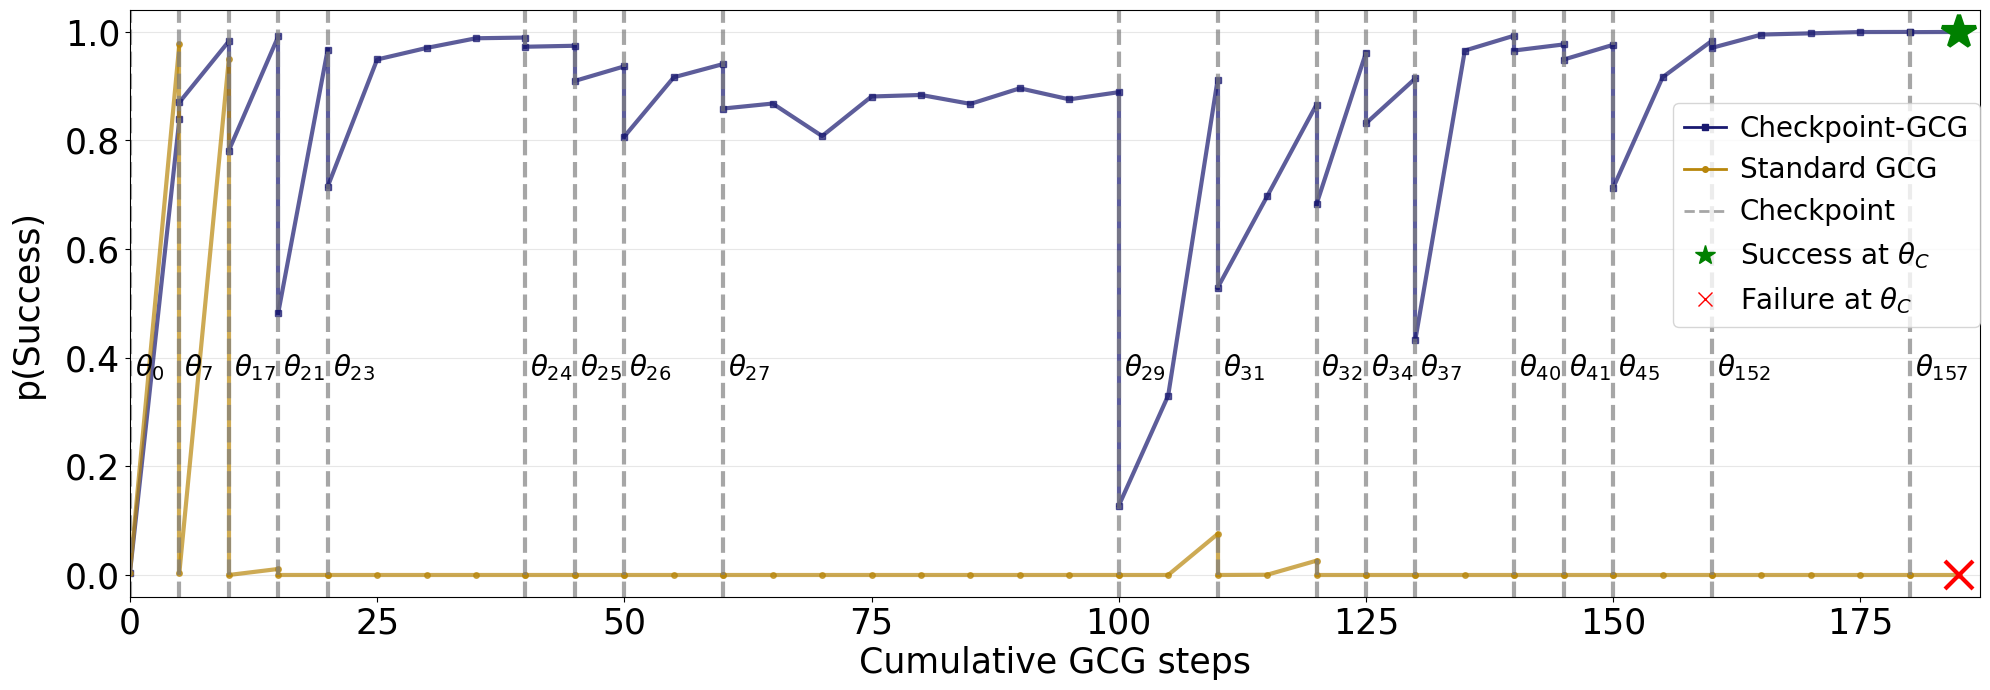

In [32]:
# sample 83 - entire checkpoint-gcg attack (all checkpoints where checkpoint-gcg made >0 steps)
checkpoints_plotted = [
    0,
    7,
    17,
    21,
    23,
    24,
    25,
    26,
    27,
    29,
    31,
    32,
    34,
    37,
    40,
    41,
    45,
    152,
    157,
]
checkpoint_nums = [f"checkpoint_{num}.jsonl" for num in checkpoints_plotted]

for sample_id in [83]:
    gradnorm_folder = llama_indiv_sample_gradnorm_folder + f"/sample_{sample_id}"
    baseline_folder = (
        llama_indiv_sample_per_checkpoint_baseline_folder + f"/sample_{sample_id}"
    )

    gradnorm_filepaths = get_files_in_folder(
        gradnorm_folder,
        file_keyword="checkpoint",
        selected_file_kw_values=checkpoint_nums,
    )

    baseline_filepaths = get_files_in_folder(
        baseline_folder,
        file_keyword="checkpoint",
        selected_file_kw_values=checkpoint_nums,
    )

    # Combine both algorithms' filepaths
    filepaths_lists_by_algo = [gradnorm_filepaths, baseline_filepaths]

    # Define titles and algorithm names
    algorithm_names = ["Checkpoint-GCG", "Standard GCG", "Alignment checkpoint"]
    algorithm_colors = ["midnightblue", "darkgoldenrod"]

    # Plot the comparison
    plot_successprob_individual_sample(
        filepaths_lists_by_algo=filepaths_lists_by_algo,
        main_title=f"p(Success) vs GCG steps for Sample ID {sample_id}",
        figsize=(20, 7),
        algo_names=algorithm_names,
        algo_colors=algorithm_colors,
        algo_final_successes=[True, False],
        font_size=25,
        font_size_theta=20,
        success_marker_size=20,
        line_weight=3,
    )